# Graph model: The spread of SARS-CoV-2

[Source](https://juliadynamics.github.io/Agents.jl/stable/examples/sir/) from Agents.jl examples

Here we add one more category of individuals: those who are infected, but do not know it. Transmission rate for infected and diagnosed individuals is lower than infected and undetected.

In [1]:
using Agents, Random
using Agents.DataFrames, Agents.Graphs
using StatsBase: sample, Weights
using LinearAlgebra: diagind
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)

## Define the Model

In [2]:
@agent struct PoorSoul(GraphAgent)
    days_infected::Int  ## number of days since is infected
    status::Symbol  ## S/I/R
end

Initialize the model

In [3]:
function make_model(;
    Ns,
    migration_rates,
    β_und,
    β_det,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, length(Ns) - 1)..., 1],
    seed = 2024,
)

    rng = Xoshiro(seed)
    @assert length(Ns) ==
    length(Is) ==
    length(β_und) ==
    length(β_det) ==
    size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
    @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

    C = length(Ns) ## Number of cities

    # normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end

    properties = (;
        Ns,
        Is,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        C,
        death_rate
    )

    space = GraphSpace(complete_graph(C))
    model = StandardABM(PoorSoul, space; agent_step!, properties, rng)

    # Add initial individuals
    for city in 1:C, n in 1:Ns[city]
        ind = add_agent!(city, model, 0, :S) ## Susceptible
    end

    # add infected individuals
    for city in 1:C
        inds = ids_in_position(city, model)
        for n in 1:Is[city]
            agent = model[inds[n]]
            agent.status = :I ## Set infected individual
            agent.days_infected = 1
        end
    end
    return model
end

make_model (generic function with 1 method)

Initialize parameters

In [4]:
function create_params(;
    C,
    max_travel_rate,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, C - 1)..., 1],
    seed = 2024,
)
    rng = Xoshiro(seed)
    Ns = rand(rng, 50:5000, C) ## City population
    β_und = rand(rng, 0.3:0.02:0.6, C) ## Undetected transmission
    β_det = β_und ./ 10 ## Detected transmission (set to 10% of undetected)

    # Migrate from city i to city j
	# People in small cities tend to migrate to bigger cities
    migration_rates = zeros(C, C)
    for c in 1:C
        for c2 in 1:C
            migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
        end
    end

    # Normalize migration rates
    maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
    # Migrate to self = 1
    migration_rates[diagind(migration_rates)] .= 1.0

    params = (;
        Ns,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        Is
    )

    return params
end

create_params (generic function with 1 method)

## Stepping functions

In [5]:
function agent_step!(agent, model)
    migrate!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
    return nothing
end

function migrate!(agent, model)
    pid = agent.pos
    m = sample(abmrng(model), 1:(model.C), Weights(model.migration_rates[pid, :]))
    if m ≠ pid
        move_agent!(agent, m, model)
    end
    return nothing
end

function transmit!(agent, model)
    agent.status == :S && return
    rate = if agent.days_infected < model.detection_time
        model.β_und[agent.pos]
    else
        model.β_det[agent.pos]
    end

    rng = abmrng(model)
    n = rate * abs(randn(rng))
    n <= 0 && return

    for contactID in ids_in_position(agent, model)
        contact = model[contactID]
        if contact.status == :S ||
           (contact.status == :R && rand(rng) ≤ model.reinfection_probability)
            contact.status = :I
            n -= 1
            n <= 0 && return
        end
    end
    return nothing
end

update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
    if agent.days_infected ≥ model.infection_period
        if rand(abmrng(model)) ≤ model.death_rate
            remove_agent!(agent, model)
        else
            agent.status = :R
            agent.days_infected = 0
        end
    end
    return nothing
end

recover_or_die! (generic function with 1 method)

Initialize the model

In [6]:
params = create_params(C = 10, max_travel_rate = 0.01)
model = make_model(; params...)

StandardABM with 24597 agents of type PoorSoul
 agents container: Dict
 space: GraphSpace with 10 positions and 45 edges
 scheduler: fastest
 properties: Ns, Is, β_und, β_det, migration_rates, infection_period, reinfection_probability, detection_time, C, death_rate

## Animation
Observable: The quantity that updates dynamically and interactively Makie plots.

In [7]:
abmobs = ABMObservable(model)

infected_fraction(m, x) = count(m[id].status == :I for id in x) / length(x)
infected_fractions(m) = [infected_fraction(m, ids_in_position(p, m)) for p in positions(m)]

infected_fractions (generic function with 1 method)

Connect (lift) observables to model states

In [8]:
fracs = lift(infected_fractions, abmobs.model)
color = lift(fs -> [cgrad(:inferno)[f] for f in fs], fracs)
title = lift(
    (m) -> "step = $(abmtime(m)), infected = $(round(Int, 100infected_fraction(m, allids(m))))%",
    abmobs.model
)

Observable("step = 0, infected = 0%")


Figure

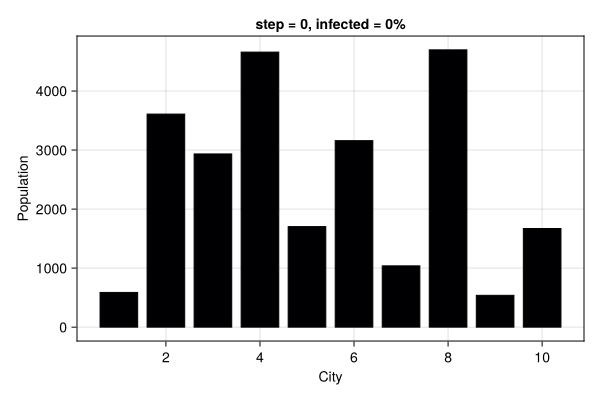

In [9]:
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; title, xlabel = "City", ylabel = "Population")
barplot!(ax, model.Ns; strokecolor = :black, strokewidth = 1, color)
fig

Animation

In [10]:
vio = Makie.Record(fig; framerate = 5) do io
    for j in 1:30
        recordframe!(io)
        Agents.step!(abmobs, 1)
    end
    recordframe!(io)
end

vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(22) open, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 5 -pixel_format rgb24 -f rawvideo -s:v 600x400 -r 5 -i pipe:0 -vf vflip -profile:v high422 -crf 20 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_ra2xwy/##video#226.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/runner/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.10.6/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=449", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "STATS_PIP=false", "PERFLOG_LOCATION_SETTING=RUNNER_PERFLOG", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/opt/hostedtoolcache/julia/1.10.6/x64/bin/../lib/julia:/home/runner/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/runner/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/runner/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/runner/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/runner/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/runner/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/runner/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/runner/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/runner/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/runner/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/runner/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/runner/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/runner/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/runner/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/runner/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/runner/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/runner/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/runner/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/runner/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/runner/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/artifacts/c8a2

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*